# 偏差与方差

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio 
import scipy.optimize as opt
import matplotlib.pyplot as plt


In [2]:
#导入数据集
def loadData(path):
    data = sio.loadmat(path)
    #data['X']等其余几项都是(12,1),将其转换为(12,)的一维向量
    return map(np.ravel,[data['X'],data['y'],data['Xval'],data['yval'],data['Xtest'],data['ytest']]) #一个列表

path = './ex5data1.mat'
X, y, Xval, yval, Xtest, ytest = loadData(path)


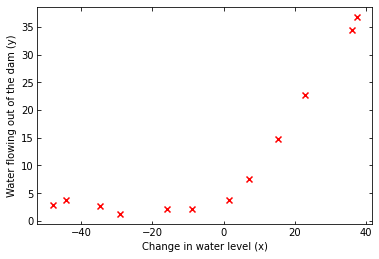

In [3]:
def visualize(X,y,theta=None,train=False):
    # plt.style.use('bmh')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.scatter(X,y,marker='x',c='r')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    ax = plt.gca() 
    ax.tick_params(top=True,right = True)
    if train:
        x = np.linspace(X.min(),X.max(),num = 20)
        y = theta[0] + theta[1]*x
        plt.plot(x,y,c='b')
    plt.show()
    return None

visualize(X,y)

In [4]:
#为X扩充一列，全为1
X, Xval, Xtest = [np.c_[np.ones((x.shape[0],1)),x] for x in [X,Xval,Xtest]]
print(X.shape)
print(Xval.shape)
print(Xtest.shape)

(12, 2)
(21, 2)
(21, 2)


## 1.损失函数和梯度(不加正则项)

In [5]:
def cost(theta,X,y):
    m = X.shape[0]
    y_pre = np.dot(X,theta) #(m,1)
    term = y_pre - y
    return (term*term).sum()/(2*m)

theta = np.ones(2)
cost(theta,X,y)

303.9515255535976

In [6]:
def gradient(theta,X,y):
    m = X.shape[0]
    y_pre = np.dot(X,theta) #(m,1)

    error = (y_pre-y).reshape(-1,1)
    grad = np.dot(error.T,X)/m #(1,2)
    return grad.flatten()  #(2,)
gradient(theta,X,y)

array([-15.30301567, 598.16741084])

## 2.损失函数和梯度(加入正则项)

In [7]:
def regularizedCost(theta,X,y,l=1):
    m = X.shape[0]
    term1 = cost(theta,X,y)
    term2 = (theta[1:]*theta[1:]).sum()*l/(2*m)
    return term1 + term2

regularizedCost(theta,X,y,l=1)

303.9931922202643

In [8]:
def regularizedGradient(theta,X,y,l=1):
    m = X.shape[0]
    y_pre = np.dot(X,theta) #(m,1)

    error = (y_pre-y).reshape(-1,1)
    grad = np.dot(error.T,X)/m #(1,2)
    grad = grad.flatten()
    grad[1:] += l/m*theta[1:] #第一项偏差项不需要正则化
    return grad

regularizedGradient(theta,X,y)

array([-15.30301567, 598.25074417])

## 3.训练模型

In [9]:
def train(X,y,l=1):
    theta = np.ones((X.shape[1]))

    res = opt.minimize(
        fun = regularizedCost,
        x0 = theta,
        args=(X,y,l),
        method = 'TNC',
        jac = regularizedGradient
    )
    return res['x']

trainTheta = train(X,y,l=0)
print(trainTheta)



[13.08790398  0.36777923]


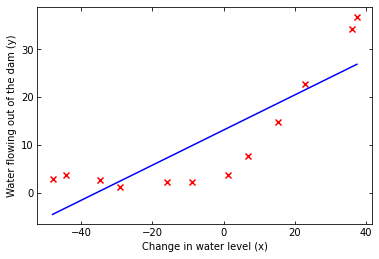

In [10]:
#可视化训练效果
visualize(X[:,1],y,trainTheta,train=True)

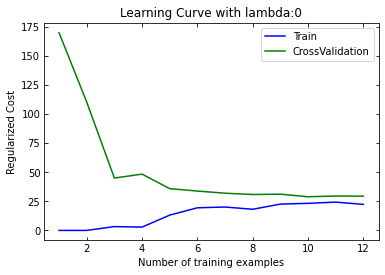

In [11]:
#绘制learningCurve曲线
def plotLearningCurve(X,y,Xval,yval,l=1):
    m = X.shape[0]
    train_cost = []
    cv_cost = []
    for i in range(1,m+1):
        trainTheta = train(X[:i,:],y[:i],l=l)
        tc = regularizedCost(trainTheta,X[:i,:],y[:i],l=l)
        cc = regularizedCost(trainTheta,Xval,yval,l=l)
        train_cost.append(tc)
        cv_cost.append(cc)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.plot(np.arange(1,m+1),train_cost,c='b',label='Train')
    plt.plot(np.arange(1,m+1),cv_cost,c='g',label='CrossValidation')
    plt.legend()
    plt.xlabel('Number of training examples')
    plt.ylabel('Regularized Cost')
    plt.title('Learning Curve with lambda:'+str(l))
    ax = plt.gca() 
    ax.tick_params(top=True,right = True)
    plt.show()
    return None

plotLearningCurve(X,y,Xval,yval,l=0)

## 4.加入多项式特征

In [12]:
def ploy_features(X,power):
    for i in range(2,power+1):
        X = np.c_[X,np.power(X[:,1],i)]
    return X
print(X[:2,:])
Xp = ploy_features(X,8)
print('power为3次方，此时的X:')
print(Xp[:1,:])

[[  1.         -15.93675813]
 [  1.         -29.15297922]]
power为3次方，此时的X:
[[ 1.00000000e+00 -1.59367581e+01  2.53980260e+02 -4.04762197e+03
   6.45059724e+04 -1.02801608e+06  1.63832436e+07 -2.61095791e+08
   4.16102047e+09]]


In [13]:
def featureNormalization(X):
    X = X.copy()
    #第一类不需要归一化，非则会变成nan
    for i in range(1,X.shape[1]): 
        X[:,i] = (X[:,i] - X[:,i].mean())/X[:,i].std()
    return X

In [14]:
def mean_variance(X):
    mean_list = []
    var_list = []
    #第一类不需要归一化，非则会变成nan
    for i in range(1,X.shape[1]): 
        mean_list.append(X[:,i].mean())
        var_list.append(X[:,i].std())
    return mean_list,var_list

mean_list,var_list = mean_variance(Xp) #含有8个元素的列表，方便后面画图

In [15]:
#加入多项式项
X, Xval, Xtest = [ploy_features(x,power=8) for x in [X, Xval, Xtest]]
X_norm, Xval_norm, Xtest_norm = [featureNormalization(x) for x in [X, Xval, Xtest]]
print(X_norm.shape)
print(Xval_norm.shape)
print(Xtest_norm.shape)
print(X_norm[:5,:])

(12, 9)
(21, 9)
(21, 9)
[[ 1.00000000e+00 -3.78243704e-01 -7.88662325e-01  1.90328720e-01
  -7.37591303e-01  3.20251970e-01 -6.17151602e-01  3.59835014e-01
  -5.31091256e-01]
 [ 1.00000000e+00 -8.38920100e-01  1.31420204e-03 -2.58961742e-01
  -3.41564822e-01  9.75492734e-02 -4.55196644e-01  2.66773432e-01
  -4.68873807e-01]
 [ 1.00000000e+00  1.43871736e+00  6.10831582e-01  1.30534069e+00
   2.56220001e-01  1.02186338e+00 -1.26962121e-02  7.90210009e-01
  -1.77926980e-01]
 [ 1.00000000e+00  1.48412330e+00  7.38068463e-01  1.42031240e+00
   4.13121830e-01  1.15534830e+00  1.31223708e-01  9.10700224e-01
  -6.22895388e-02]
 [ 1.00000000e+00 -1.49791929e+00  1.93643966e+00 -2.12774745e+00
   2.43510061e+00 -2.51876748e+00  2.71792174e+00 -2.76331690e+00
   2.88908182e+00]]


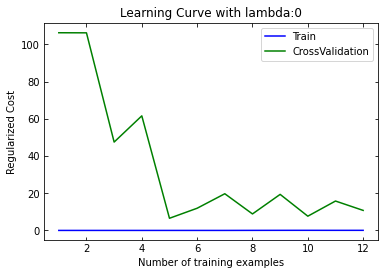

In [16]:
plotLearningCurve(X_norm, y, Xval_norm, yval, l=0)

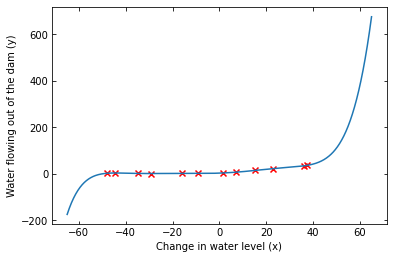

In [17]:
#可视化训练后的拟合情况
def plot_fit(X,y,theta,mean,var):
    # plt.style.use('bmh')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.scatter(X,y,marker='x',c='r')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    ax = plt.gca() 
    ax.tick_params(top=True,right = True)

    #绘制拟合的曲线，由于涉及到归一化，所以比较繁琐
    x = np.linspace(-65,65,1000)
    y = theta[0]
    power = len(mean)
    for i in range(power):
        xi = (np.power(x,i+1)-mean[i])/var[i]
        y += theta[i+1]*xi
    plt.plot(x,y)
    plt.show()
    return None

trainTheta = train(X_norm,y,l=0)
plot_fit(X[:,1],y,trainTheta,mean_list,var_list)

注意：
* 特征多项式化之后必须要归一化，不然得不到答案中的学习曲线，说明了特征归一化的重要性；
* 特征归一化之后，若想要绘制训练之后模型的拟合情况，需要将输入特征进行归一化。

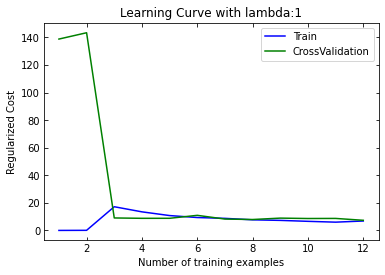

In [18]:
#lambda=1的情况
plotLearningCurve(X_norm, y, Xval_norm, yval, l=1)

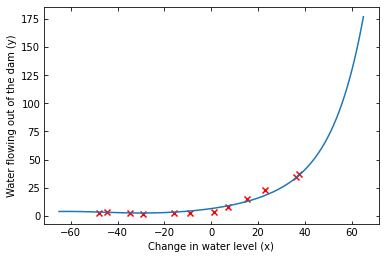

In [19]:
trainTheta = train(X_norm,y,l=1)
plot_fit(X[:,1],y,trainTheta,mean_list,var_list)

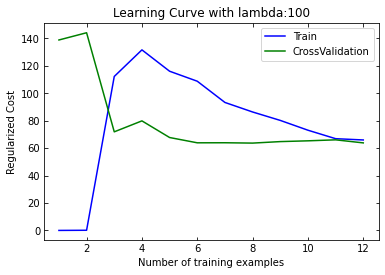

In [20]:
#lambda=100的情况
plotLearningCurve(X_norm, y, Xval_norm, yval, l=100)

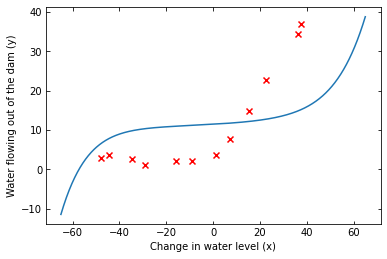

In [21]:
trainTheta = train(X_norm,y,l=100)
plot_fit(X[:,1],y,trainTheta,mean_list,var_list)

## 5.选择最佳的lambda

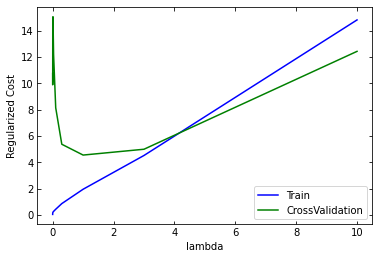

[10.754012578519951,
 9.893676883329494,
 14.439414154225961,
 15.067431810855563,
 12.195872065547544,
 8.149434509770499,
 5.377983539737107,
 4.556542701779306,
 4.998824430598815,
 12.436950696259121]

In [22]:
def choose_l(X,y,Xval,yval,l_list):
    m = len(l_list)
    train_cost = []
    cv_cost = []
    for l in l_list:
        trainTheta = train(X,y,l=l)
        tc = regularizedCost(trainTheta,X,y,l=0)
        cc = regularizedCost(trainTheta,Xval,yval,l=0)
        train_cost.append(tc)
        cv_cost.append(cc)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.plot(l_list,train_cost,c='b',label='Train')
    plt.plot(l_list,cv_cost,c='g',label='CrossValidation')
    plt.legend()
    plt.xlabel('lambda')
    plt.ylabel('Regularized Cost')
    ax = plt.gca() 
    ax.tick_params(top=True,right = True)
    plt.show()
    return cv_cost

l_list = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
choose_l(X_norm, y, Xval_norm, yval, l_list)


In [23]:
#在test测试集上选择最佳lambda
test_cost = []
for l in l_list:
        trainTheta = train(X_norm,y,l=l)
        tc = regularizedCost(trainTheta,Xtest_norm,ytest,l=0)
        test_cost.append(tc)
print(test_cost)


[10.190363918845119, 11.08044079674378, 11.310694853436788, 10.988497711047026, 10.21901847097632, 8.953968297734606, 7.745102441410812, 7.8515797985656475, 11.770329622320522, 26.894076418692688]


所以lambda=0.3是最佳的选择